In [1]:
!pip install prophet

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('product_quantity.txt')
data.head()

,product_id,product_date,orderattribute1,orderattribute2,orderattribute3,orderattribute4,ciiquantity,ordquantity,price
0,1,2014-06-21,2,1,1,1,0,1,-1
1,1,2014-09-03,2,1,1,1,1,3,153
2,1,2014-09-26,2,1,1,1,0,3,-1
3,1,2014-11-28,2,1,1,1,0,4,-1
4,1,2014-01-11,2,1,1,1,1,1,153


In [4]:
data.describe()

,product_id,orderattribute1,orderattribute2,orderattribute3,orderattribute4,ciiquantity,ordquantity,price
count,1.959676e+06,1.959676e+06,1.959676e+06,1.959676e+06,1.959676e+06,1.959676e+06,1.959676e+06,1.959676e+06
mean,1.785016e+03,1.815664e+00,1.320328e+00,1.159598e+00,1.044129e+00,4.737512e+00,8.186869e+00,2.215342e+02
std,1.110163e+03,8.309744e-01,4.666029e-01,3.662327e-01,2.053822e-01,7.727927e+00,1.267968e+01,2.801794e+02
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,-1.231000e+03
25%,8.210000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,8.200000e+01
50%,1.680000e+03,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,1.580000e+02
75%,2.698000e+03,3.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00,9.000000e+00,2.790000e+02
max,4.000000e+03,3.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.290000e+02,5.450000e+02,2.750000e+04


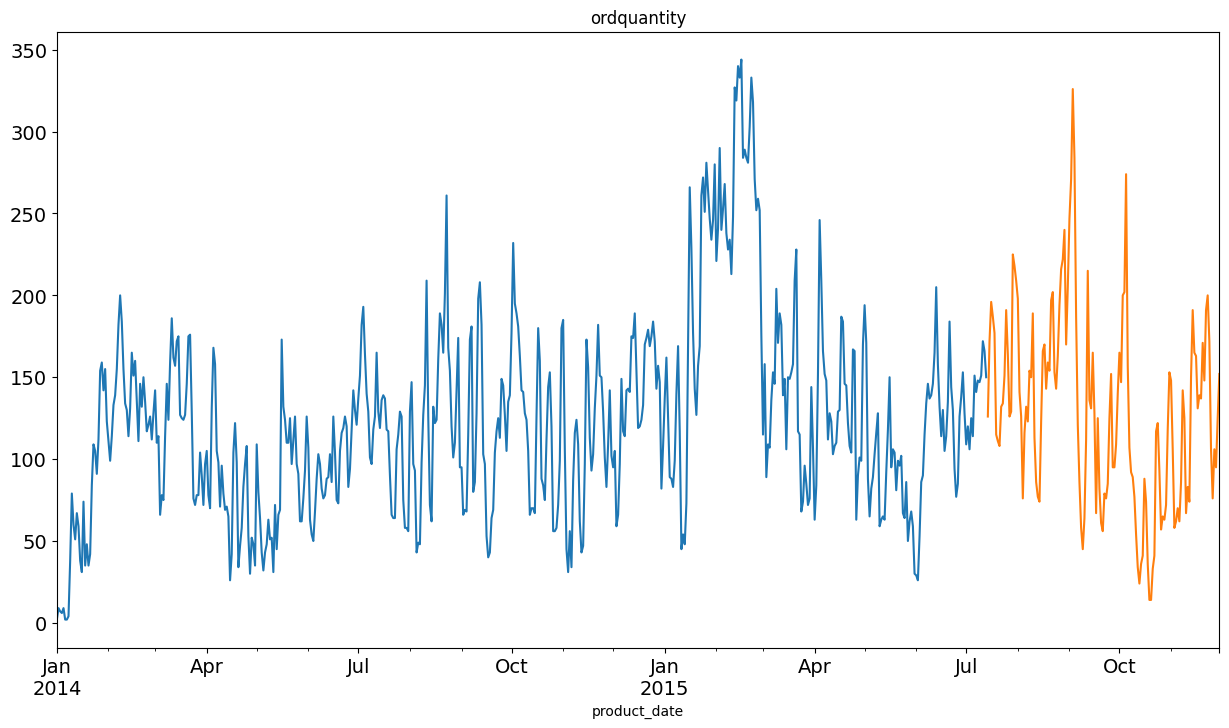

In [5]:
# Extract product data and adjust time format
df = data[data['product_id'] == 1526].sort_values('product_date')
df['product_date'] = pd.to_datetime(df['product_date'])

# Aggregate the table by the date dimension,
df = df.groupby(['product_date'])['ordquantity'].agg(['sum','count']).reset_index().set_index('product_date')
df.columns = ['ordquantity','ords']

# Dividing the training and testing sets according to the 8/2 ratio
split_point = int(len(df)*0.8)
df_train = df[:split_point]
df_test = df[split_point:]
X, y =  df['ords'], df['ordquantity']
X_train, y_train, X_test, y_test = df_train['ords'], df_train['ordquantity'], df_test['ords'], df_test['ordquantity']

# draw
y_train.plot(figsize=(15,8), title= 'ordquantity', fontsize=14)
y_test.plot(figsize=(15,8), title= 'ordquantity', fontsize=14)
plt.show()

In [6]:
# adjust time format
X_train.index = pd.to_datetime(X_train.index)
X_test.index = pd.to_datetime(X_test.index)

moving average

For a given time window, the value at the next moment can be predicted

Pros: simple, no features required

Cons: can only predict one step

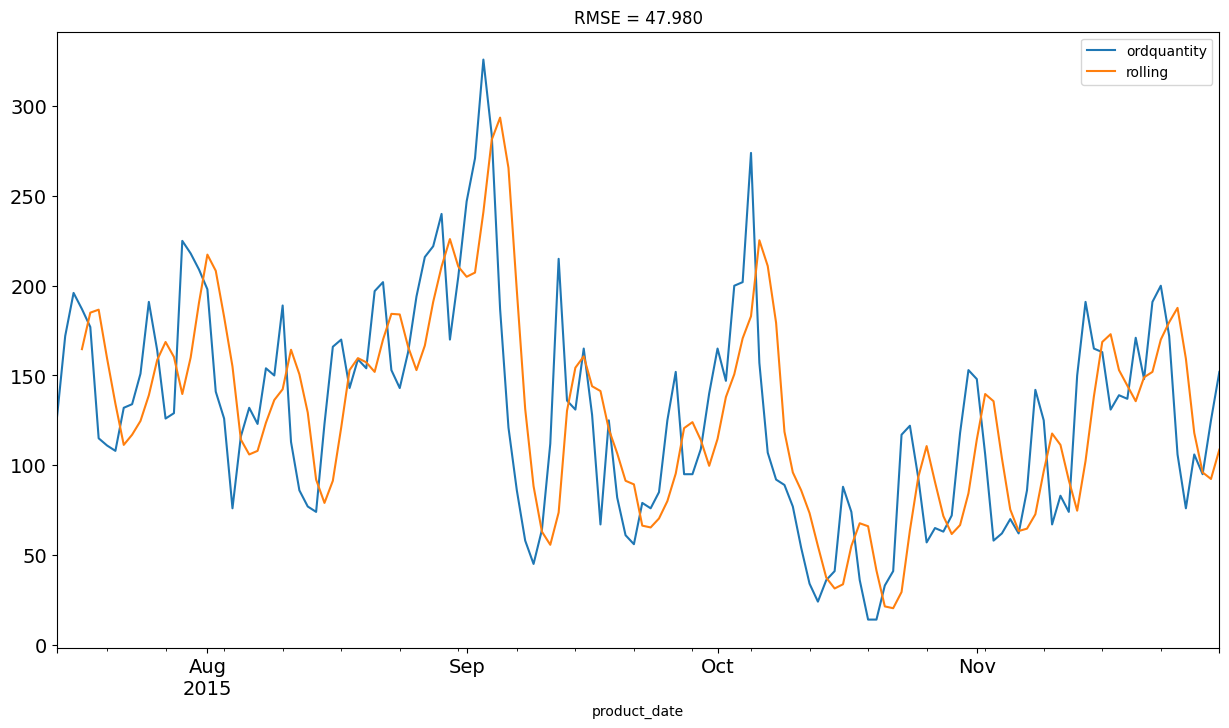

In [7]:
# a simple sliding average function
def simple_rolling(df, y, window):
    df['rolling'] = df[y].rolling(window=window).mean().shift()
    rmse = np.sqrt(mean_squared_error(df.dropna()[y], df.dropna()['rolling']))

    df[y].plot(figsize=(15,8), legend= 'true', fontsize=14)
    df['rolling'].plot(figsize=(15,8), legend= 'pred', fontsize=14)
    plt.title(f'RMSE = {rmse:.3f}')
    plt.show()

simple_rolling(df_test, 'ordquantity', 3)    # Predictions can be uniformly added to df_test, making it easy to compare predictions from multiple models.

weight

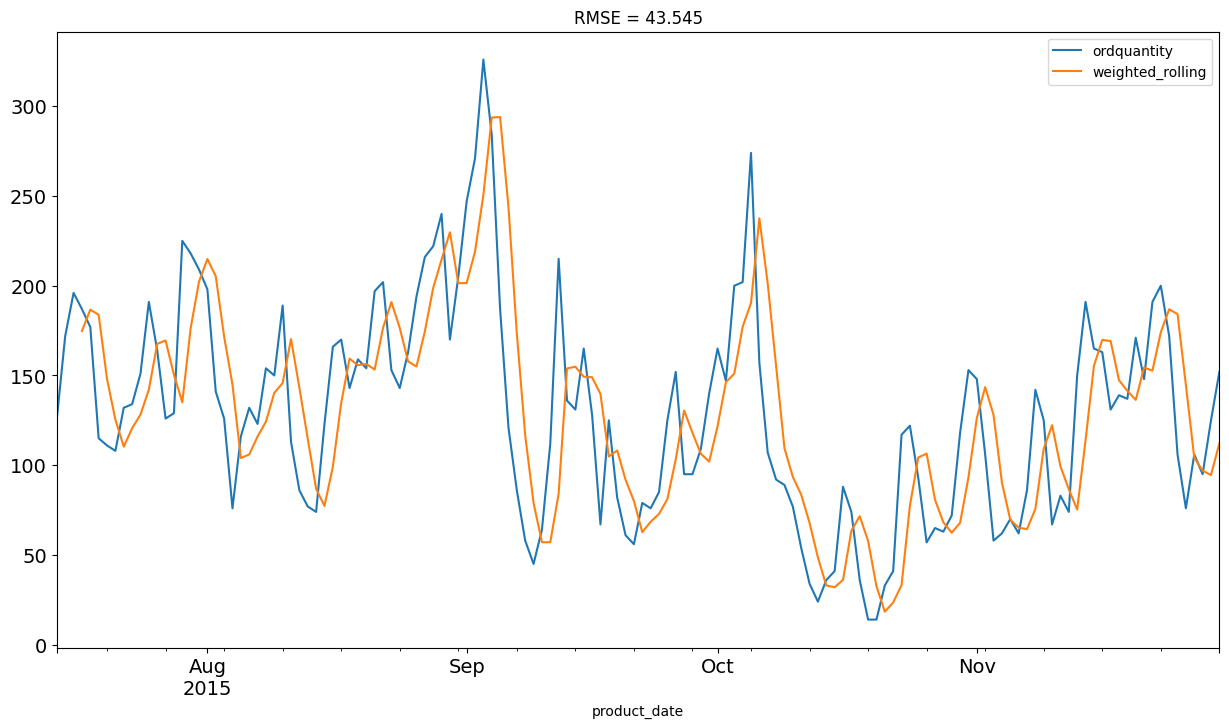

In [8]:
# a weighted sliding average function
def weighted_rolling(df, y, weights):
    df['weighted_rolling'] = np.nan
    df['weighted_rolling'][len(weights):] = np.convolve(df[y], weights, mode='valid')[:-1]
    rmse = np.sqrt(mean_squared_error(df.dropna()[y], df.dropna()['weighted_rolling']))

    df[y].plot(figsize=(15,8), legend= 'true', fontsize=14)
    df['weighted_rolling'].plot(figsize=(15,8), legend= 'pred', fontsize=14)
    plt.title(f'RMSE = {rmse:.3f}')
    plt.show()

weights = [0.5, 0.3, 0.2]
weighted_rolling(df_test, 'ordquantity', weights)

**ARIMA**

Combines autoregressive (AR), difference (I) and moving average (MA) components

Advantages: can handle non-stationary data, model has a theoretical basis

Disadvantages: need to determine the model order, computationally complex

Smoothness testing

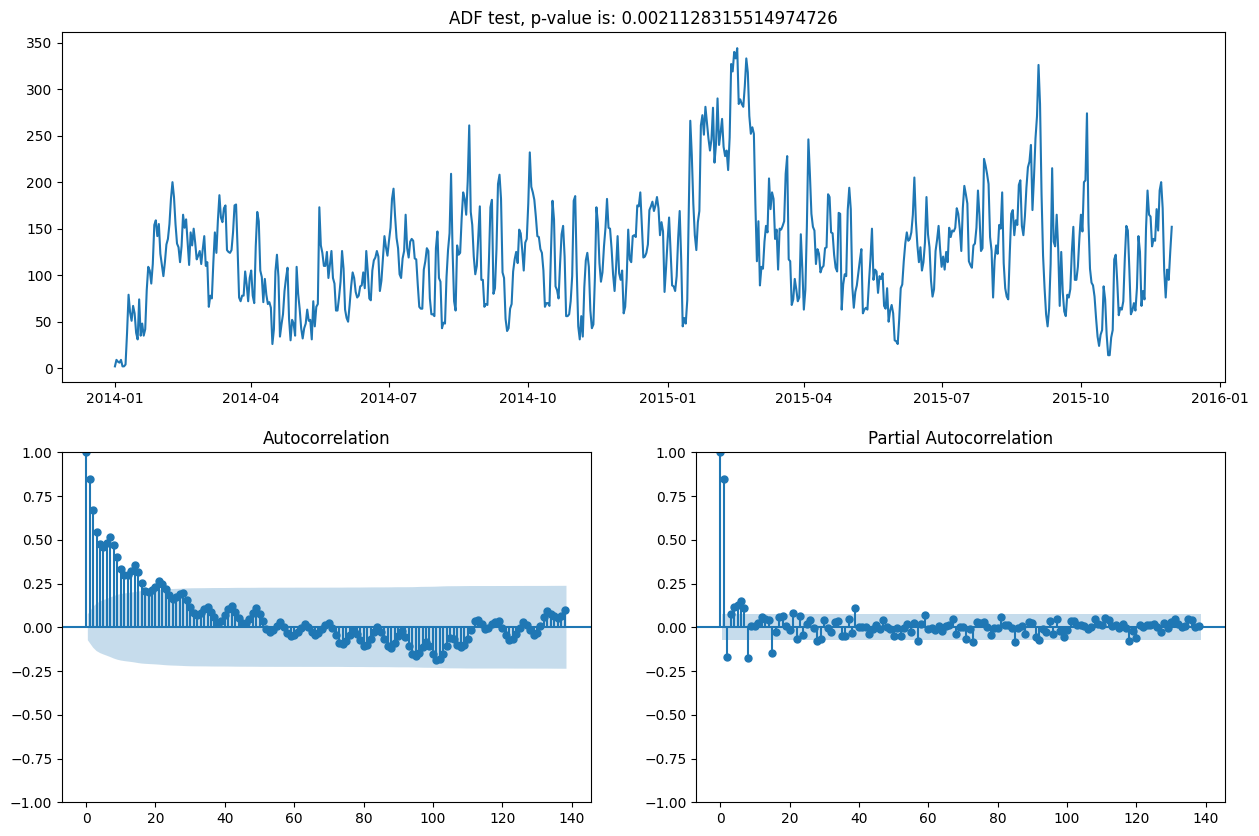

In [9]:
# Data Diagnostic Functions
def diagnosis(ts):
    results = adfuller(ts)
    results_str = 'ADF test, p-value is: {}'.format(results[1])

    plt.figure(figsize=(15,10))
    grid = plt.GridSpec(2, 2)
    ax1 = plt.subplot(grid[0, :])
    ax2 = plt.subplot(grid[1, 0])
    ax3 = plt.subplot(grid[1, 1])

    ax1.plot(ts)
    ax1.set_title(results_str)
    plot_acf(ts, lags=int(len(ts) / 5 - 1), ax=ax2)
    plot_pacf(ts, lags=int(len(ts) / 5 - 1), ax=ax3)
    plt.show()


diagnosis(y)

ADF test p<<0.05, data stable

white noise detection

In [10]:
acorr_ljungbox(y_train)

,lb_stat,lb_pvalue
1,415.912602,1.892897e-92
2,689.944556,1.515107e-150
3,881.568934,8.806397e-191
4,1038.361810,1.732815e-223
5,1189.549572,5.389891e-255
6,1355.411712,1.092498e-289
7,1541.205548,0.000000e+00
8,1697.881976,0.000000e+00
9,1812.354133,0.000000e+00
10,1898.315288,0.000000e+00


On each order, p<<0.05, not white noise, satisfies modelling conditions

In [11]:
# modelling
model = SARIMAX(
    endog=y_train,
    exog=X_train,                           #Exogenous variables (characteristics)
    order=[1,0,0],                          #The upper diagnostic provides a set of
    seasonal_order=[0,1,1,28]
).fit(disp=False)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          ordquantity   No. Observations:                  559
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 28)   Log Likelihood               -2526.535
Date:                              Mon, 30 Dec 2024   AIC                           5061.069
Time:                                      22:18:40   BIC                           5078.168
Sample:                                  01-01-2014   HQIC                          5067.761
                                       - 07-13-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ords           8.9551      1.714      5.224      0.000       5.595      12.315
ar.L1          0.8911      0.020     45.218      0.000       0.852       0.930
ma.S.L28      -0.9988      2.596     -0.385      0.700      -6.086       4.089
sigma2       677.7088   1750.084      0.387      0.699   -2752.394    4107.811
===================================================================================
Ljung-Box (L1) (Q):                   2.80   Jarque-Bera (JB):                12.67
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

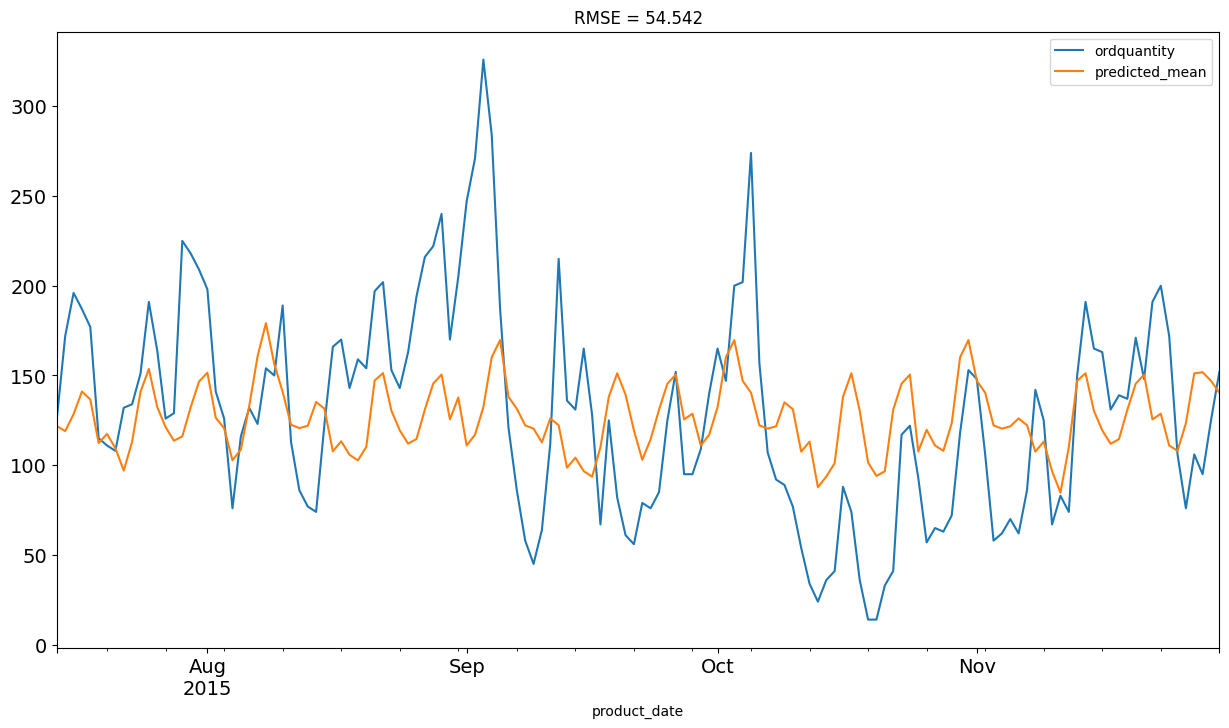

In [12]:
# model prediction
fcst = model.forecast(len(y_test),exog=X_test)

# modelling assessment
df_test['sarima'] = fcst
rmse = np.sqrt(mean_squared_error(y_test, fcst))
y_test.plot(figsize=(15,8), legend= 'true', fontsize=14)
fcst.plot(figsize=(15,8), legend= 'pred', fontsize=14)
plt.title(f'RMSE = {rmse:.3f}')
plt.show()

Prophet

Developed by Facebook to automatically handle missing values and outliers

Pros: automatically detects seasonality, easy to use

Cons: possible overfitting, high computational resource requirements

In [13]:
# Collating data sets
prophet_df = df_train.reset_index()
prophet_df.columns = ['ds','y','x1']

# modelling
prophet_model = Prophet(
    growth='linear',
    changepoints=None,                         #Specify the point in time at which the trend changes, not given to auto-customise.
    n_changepoints=5,
    changepoint_range=0.8,                     #changepoints occur in the first n% part of the sequence
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
)

prophet_model.fit(prophet_df)

# # anticipate
future = pd.merge(y_test, X_test, left_index=True, right_index=True).reset_index()
future.columns = ['ds','y','x1']
prophet_fcst = prophet_model.predict(future)
prophet_fcst = prophet_fcst.set_index('ds')['yhat']


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ntu6nt1/nr8h6swu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ntu6nt1/jf00mi29.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10473', 'data', 'file=/tmp/tmp3ntu6nt1/nr8h6swu.json', 'init=/tmp/tmp3ntu6nt1/jf00mi29.json', 'output', 'file=/tmp/tmp3ntu6nt1/prophet_modellkknh602/prophet_model-20241230221841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
22:18:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3ntu6nt1/j_z37tyl.json
DE

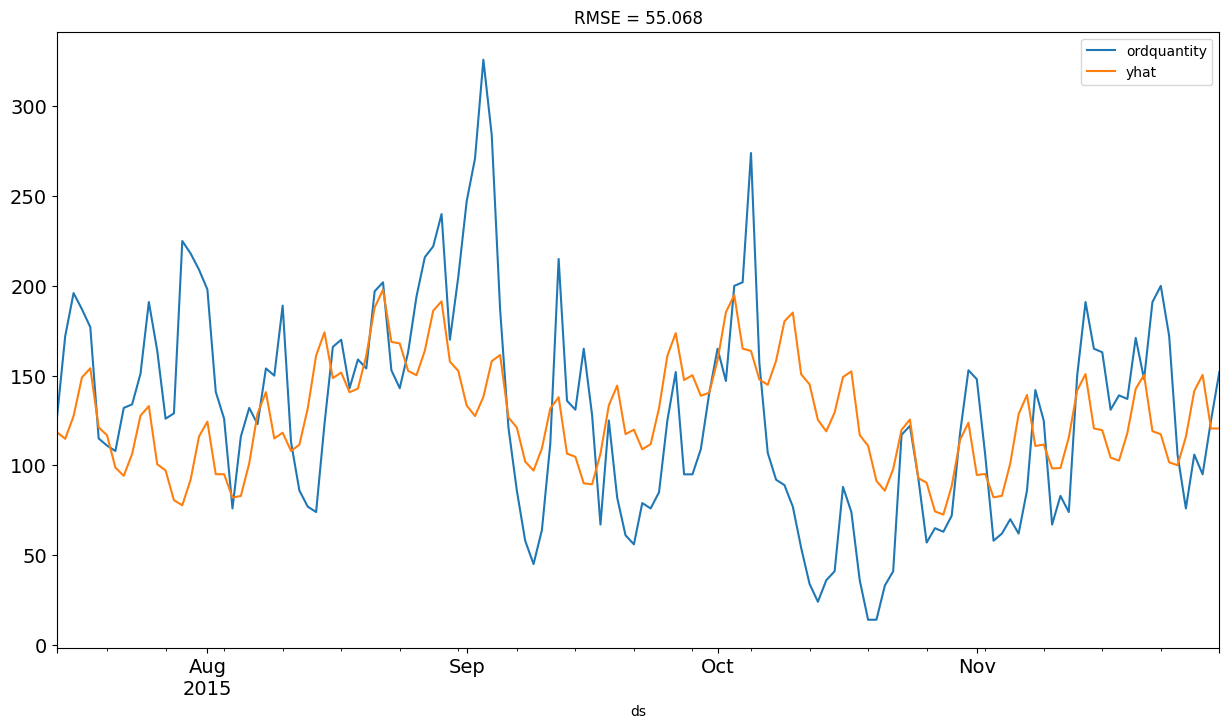

In [14]:
# modelling assessment
df_test['prophet'] = prophet_fcst
rmse = np.sqrt(mean_squared_error(y_test, prophet_fcst))
y_test.plot(figsize=(15,8), legend= 'true', fontsize=14)
prophet_fcst.plot(figsize=(15,8), legend= 'pred', fontsize=14)
plt.title(f'RMSE = {rmse:.3f}')
plt.show()

LSTM

Deep learning method that learns long-term dependencies

Pros: can capture complex non-linear relationships

Cons: requires large amounts of data for training, complex parameter tuning

In [15]:
# Set two important parameters
# step
timesteps = 28
# Number of features
features = 2

In [16]:
# feature processing
scaler1 = MinMaxScaler()
scaler1.fit(np.array(y).reshape(-1, 1))
scaled_y_train = scaler1.transform(np.array(y_train).reshape(-1, 1))
scaled_y_test = scaler1.transform(np.array(y_test).reshape(-1, 1))

scaler2 = MinMaxScaler()
scaler2.fit(np.array(X).reshape(-1, 1))
scaled_X_train = scaler2.transform(np.array(X_train).reshape(-1, 1))
scaled_X_test = scaler2.transform(np.array(X_test).reshape(-1, 1))

In [17]:
# X needs to be 3-dimensional [samples, timesteps, features], y is 2-dimensional, and is handled by the following function
def prepare_data(X, y, timesteps):
    Xs = []
    Ys = []

    for i in range(len(X) - timesteps):
        a = X[i:(i + timesteps)]
        Xs.append(a)
        Ys.append(y[i + timesteps])

    return np.array(Xs), np.array(Ys)


scaled_X_train, scaled_y_train = prepare_data(np.hstack((scaled_X_train,scaled_y_train)), scaled_y_train, timesteps=timesteps)
scaled_X_test, scaled_y_test = prepare_data(np.hstack((scaled_X_test,scaled_y_test)), scaled_y_test, timesteps=timesteps)

# Check the shape of the processed training set, test set
print(scaled_X_train.shape)
print(scaled_X_test.shape)
print(scaled_y_train.shape)
print(scaled_y_test.shape)

(531, 28, 2)
(112, 28, 2)
(531, 1)
(112, 1)


In [18]:
# modelling
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=False, input_shape = (timesteps, features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 200)                 │         162,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 162,601 (635.16 KB)

 Trainable params: 162,601 (635.16 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(scaled_X_train, scaled_y_train, batch_size=16, epochs = 30)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0541
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0171
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0146
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0156
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0131
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0154
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0133
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0126
Epoch 9/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0122
Epoch 10/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0123
Epoch 11/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0132
Epoch 12/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0109
Epoch 13/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0120
Epoch 14/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0107
Epoch 15/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0101
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

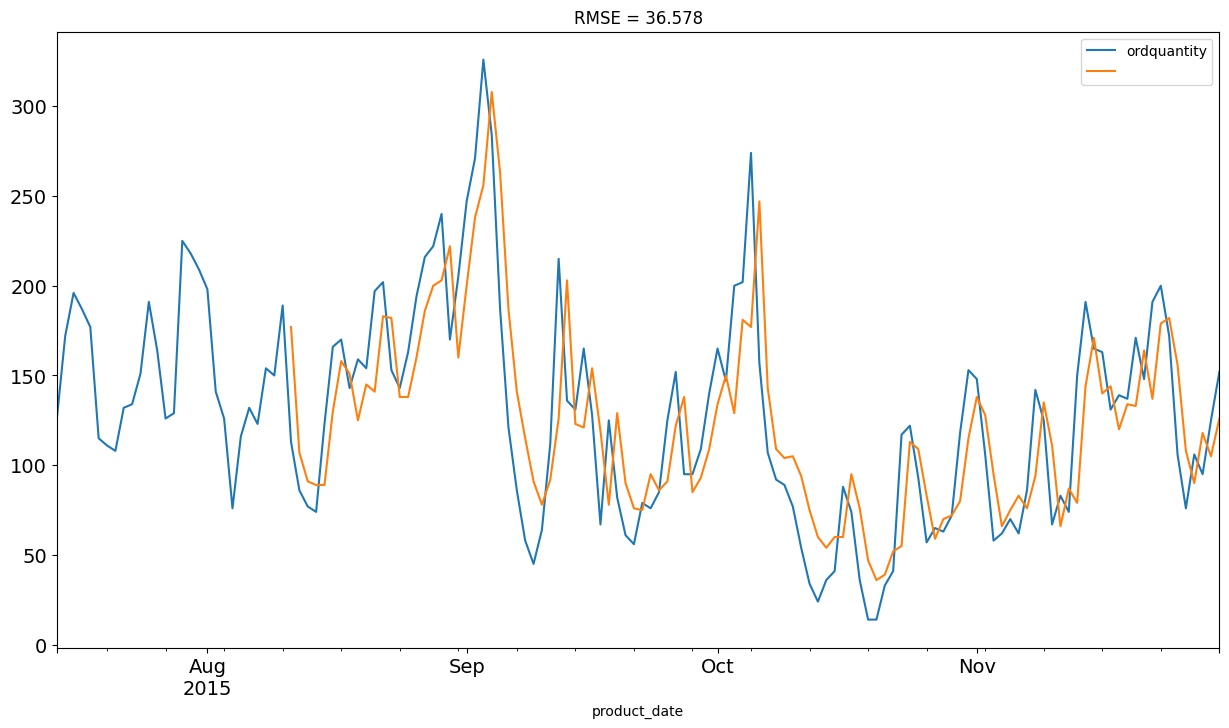

In [20]:
# prediction
y_pred = []

# step-by-step prediction
for i in range(len(scaled_X_test)):
    current_batch = scaled_X_test[i].reshape(1, scaled_X_test[i].shape[0], scaled_X_test[i].shape[1])
    pred = model.predict(current_batch)[0]
    y_pred.append(pred)

# Convert back to the original scale.
y_pred_transformed = scaler1.inverse_transform(y_pred)
y_pred_transformed = np.round(y_pred_transformed,0)
y_pred_final = y_pred_transformed.astype(int).reshape(-1)
y_pred_final = pd.Series(y_pred_final, index=y_test[timesteps:].index)

# modelling assessment
df_test['lstm'] = np.NaN
df_test['lstm'][timesteps:] = y_pred_final
rmse = np.sqrt(mean_squared_error(y_test[timesteps:], y_pred_final))
y_test.plot(figsize=(15,8), legend= 'true', fontsize=14)
y_pred_final.plot(figsize=(15,8), legend= 'pred', fontsize=14)
plt.title(f'RMSE = {rmse:.3f}')
plt.show()

**final**

<Axes: xlabel='product_date'>

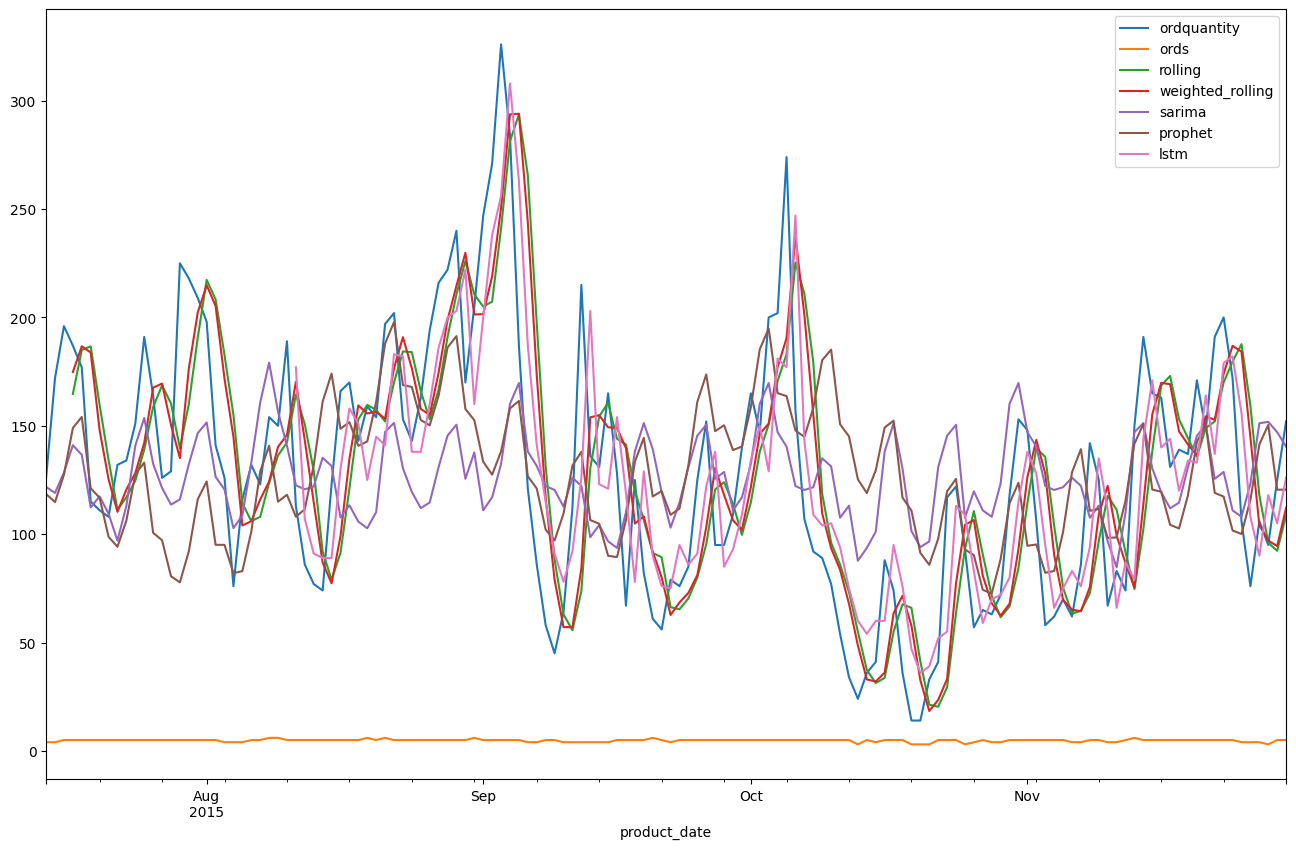

In [21]:
df_test.plot(figsize=(16,10), )